In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob

In [2]:
# Define the path pattern for all tracking datasets
tracking_files_pattern = "data/tracking_week_*.csv"

# Read and concatenate all tracking datasets
tracking_files = glob.glob(tracking_files_pattern)
tracking_data = pd.concat([pd.read_csv(file) for file in tracking_files], ignore_index=True)

# Path for plays dataset
plays_path = 'data/plays.csv'

# Load plays dataset
plays = pd.read_csv(plays_path)

# Merge tracking data with plays data on 'gameId' and 'playId'
merged_data = pd.merge(tracking_data, plays, on=['gameId', 'playId'], how='inner')

# # Save the merged data to a file
# merged_data.to_csv('Merged_Data.csv', index=False)

print("Tracking and plays data merged successfully!")

Tracking and plays data merged successfully!


In [3]:
# merged_path = 'Merged_Data.csv'
# merged_data = pd.read_csv(merged_path)

# Filter the dataset for before-snap data
before_snap_data = merged_data[merged_data['frameType'] == 'BEFORE_SNAP']

In [4]:
# Select predictors (before-snap features) and target (post-snap column)
predictors = [
    'event',
    'offenseFormation',
    'receiverAlignment',
    'playClockAtSnap',
    'absoluteYardlineNumber',
    'quarter',
    'down',
    'yardsToGo',
    'pff_passCoverage',
    'pff_manZone',
    'gameClock'
]

target = 'passResult'

# Include 'gameId' and 'playId' in the filtered data
ids = ['gameId', 'playId']

# Filter rows where predictors and target are not NaN
filtered_data = before_snap_data[ids + predictors + [target]]
filtered_data = filtered_data.dropna(subset=predictors)

# Keep only one row for each play
filtered_data = filtered_data.groupby(['gameId', 'playId']).last().reset_index()

# Create binary target variable: 1 for 'rush' (NaN in 'passResult'), 0 for others
filtered_data['isRush'] = filtered_data['passResult'].isna().astype(int)

# Convert gameClock from 'MM:SS' format to total seconds
filtered_data['gameClock'] = filtered_data['gameClock'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if pd.notnull(x) else None
)

# Ensure the column is numeric
filtered_data['gameClock'] = pd.to_numeric(filtered_data['gameClock'])

# Print the unique values in the "passResult" column
print("Unique values in 'passResult':", filtered_data['passResult'].unique())

filtered_data.tail(15)

Unique values in 'passResult': ['C' 'R' None 'S' 'IN' 'I']


,gameId,playId,event,offenseFormation,receiverAlignment,playClockAtSnap,absoluteYardlineNumber,quarter,down,yardsToGo,pff_passCoverage,pff_manZone,gameClock,passResult,isRush
15889,2022110700,3323,line_set,SHOTGUN,3x1,18.0,23,4,3,14,Cover-3,Zone,356,C,0
15890,2022110700,3347,line_set,SHOTGUN,2x2,23.0,34,4,4,3,Cover-3 Seam,Zone,330,C,0
15891,2022110700,3375,line_set,SHOTGUN,3x1,21.0,41,4,1,10,Cover 6-Left,Zone,304,I,0
15892,2022110700,3401,line_set,SHOTGUN,2x2,8.0,41,4,2,10,Cover 6-Left,Zone,298,C,0
15893,2022110700,3458,line_set,SHOTGUN,2x2,6.0,69,4,1,10,Cover-3 Seam,Zone,267,I,0
15894,2022110700,3480,line_set,SHOTGUN,2x2,7.0,69,4,2,10,Cover-3,Zone,262,C,0
15895,2022110700,3560,shift,SHOTGUN,3x1,13.0,88,4,1,10,Quarters,Zone,250,None,1
15896,2022110700,3581,man_in_motion,SHOTGUN,2x2,5.0,82,4,2,4,Quarters,Zone,209,None,1
15897,2022110700,3602,line_set,PISTOL,2x1,14.0,75,4,1,10,Cover-3,Zone,203,None,1
15898,2022110700,3630,shift,PISTOL,2x2,7.0,75,4,2,10,Quarters,Zone,199,None,1


In [5]:
filtered_data.shape

(15904, 15)

In [6]:
# Print each column's name, datatype, and length in the filtered_data DataFrame
for column in filtered_data.columns:
    print(f"Column: {column}")
    print(f"Datatype: {filtered_data[column].dtype}")
    print(f"Length: {filtered_data[column].shape[0]}\n")

Column: gameId
Datatype: int64
Length: 15904

Column: playId
Datatype: int64
Length: 15904

Column: event
Datatype: object
Length: 15904

Column: offenseFormation
Datatype: object
Length: 15904

Column: receiverAlignment
Datatype: object
Length: 15904

Column: playClockAtSnap
Datatype: float64
Length: 15904

Column: absoluteYardlineNumber
Datatype: int64
Length: 15904

Column: quarter
Datatype: int64
Length: 15904

Column: down
Datatype: int64
Length: 15904

Column: yardsToGo
Datatype: int64
Length: 15904

Column: pff_passCoverage
Datatype: object
Length: 15904

Column: pff_manZone
Datatype: object
Length: 15904

Column: gameClock
Datatype: int64
Length: 15904

Column: passResult
Datatype: object
Length: 15904

Column: isRush
Datatype: int32
Length: 15904



In [7]:
# One-hot encode categorical columns using pd.get_dummies
encoded_categorical = pd.get_dummies(filtered_data[['event',
                       'offenseFormation',
                       'receiverAlignment',
                       'pff_manZone',
                       'pff_passCoverage']])

# Combine encoded categorical columns with numerical predictors
numerical_columns = ['playClockAtSnap',
                     'absoluteYardlineNumber',
                     'quarter',
                     'down',
                     'yardsToGo',
                     'gameClock']

X = pd.concat([encoded_categorical, filtered_data[numerical_columns]], axis=1)

# Ensure that the target variable matches the rows in the feature matrix
y = filtered_data['isRush']

# Check consistency
assert X.shape[0] == y.shape[0], "Mismatch in the number of rows between X and y!"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Fit a Random Forest model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2430
           1       0.67      0.65      0.66      1546

    accuracy                           0.74      3976
   macro avg       0.73      0.72      0.72      3976
weighted avg       0.74      0.74      0.74      3976



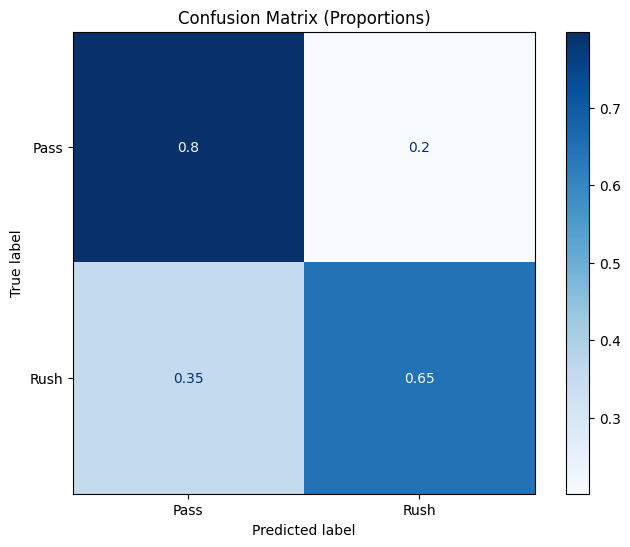

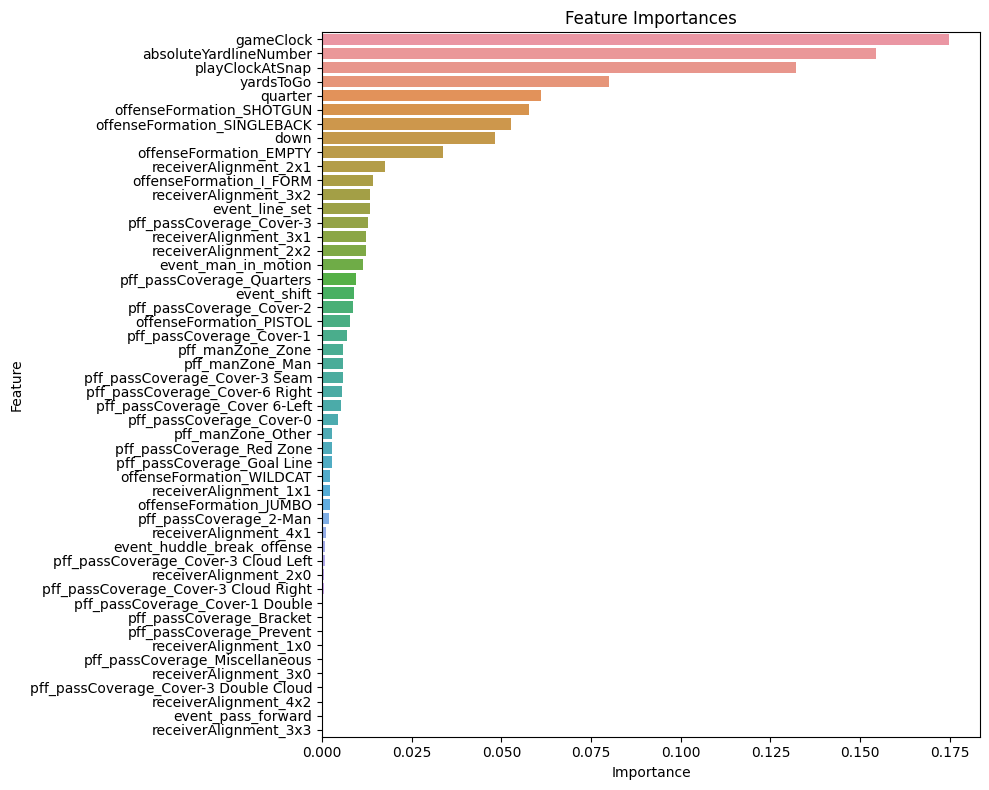

In [9]:
# Plot the confusion matrix (proportions)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Rush'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix (Proportions)")
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()